# Stability analysis between RICC and HAC to random uniform distribution $\in \left[-2\sigma, 2\sigma \right]$
Compare clustering results of a set of patches $H$ produced from RICC and clustering results of the patches from HAC applied to random unifrom distribution between -2 to +2 sigma of $H$

In [1]:
%matplotlib inline
import os
import re
import gc
import time
import pickle
import itertools
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import rand_score as NRI
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
ricc_data_basedir="/home/tkurihana/scratch-midway2/data/MODIS-CLF/stability/10021600"

In [4]:
random_data_basedir="/home/tkurihana/scratch-midway2/data/MODIS-CLF/random_uniform/10021600"

## Read individual clustering results

In [5]:
npatches = 14000 # size of H patches

In [6]:
def pkl_reader(f, varname="leaky_re_lu_21-labels", npatches=0):
    with open(f, 'rb') as f:
        data = pickle.load(f)
    var = data[varname][:npatches]
    return var

In [7]:
erank=30
layer_name='leaky_re_lu_21'

In [8]:
nclusters_list = np.arange(8,61,2).tolist() + np.arange(64,129,4).tolist() + [256]

### Clustering results from RICC
Done Exec label pool from 116 notebook: load pkl files for RICC

In [9]:
with open('./labels_pool.pkl', 'rb') as f:
    labels_pool = pickle.load(f)

### Clustering results from HAC to random distribution

In [15]:
randoms_pool = {}
## read from files or already prepared pickle
try:
    for idx, nclusters in enumerate(nclusters_list):
        tmp = []
        for rank in range(1, erank+1, 1):
            f =os.path.join(*[random_data_basedir, f"nclusters-{nclusters}",
                          "HAC","leaky_re_lu_21", f'HR{rank}', 
                          f'score-hac_10021600_HR{rank}-data.pkl'])
            _l = pkl_reader(f, varname="leaky_re_lu_21-labels", npatches=npatches)
            tmp.append(np.asarray(_l[:npatches]))
        randoms_pool[nclusters] = tmp
        print(f"NC = {nclusters} DONE")
        if idx % 5 == 0:
            gc.collect()
except:
    with open('./randoms_pool.pkl', 'rb') as f:
        randoms_pool = pickle.load(f)
    pass

-------------------
## Significance of cluster stability: Calculate RI scores

In [18]:
scores_pool = {}
for nclusters, values in labels_pool.items():
    _nris = []
    for (i,j) in itertools.combinations(np.arange(erank),2):
        u = values[i][:npatches]
        v = values[j][:npatches]
        _nris.append(NRI(u , v ) )
    scores_pool[nclusters] = _nris

In [19]:
rscores_pool = {}
for nclusters, values in randoms_pool.items():
    _nris = []
    for (i,j) in itertools.combinations(np.arange(erank),2):
        u = values[i][:npatches]
        v = values[j][:npatches]
        _nris.append(NRI(u , v ) )
    rscores_pool[nclusters] = _nris

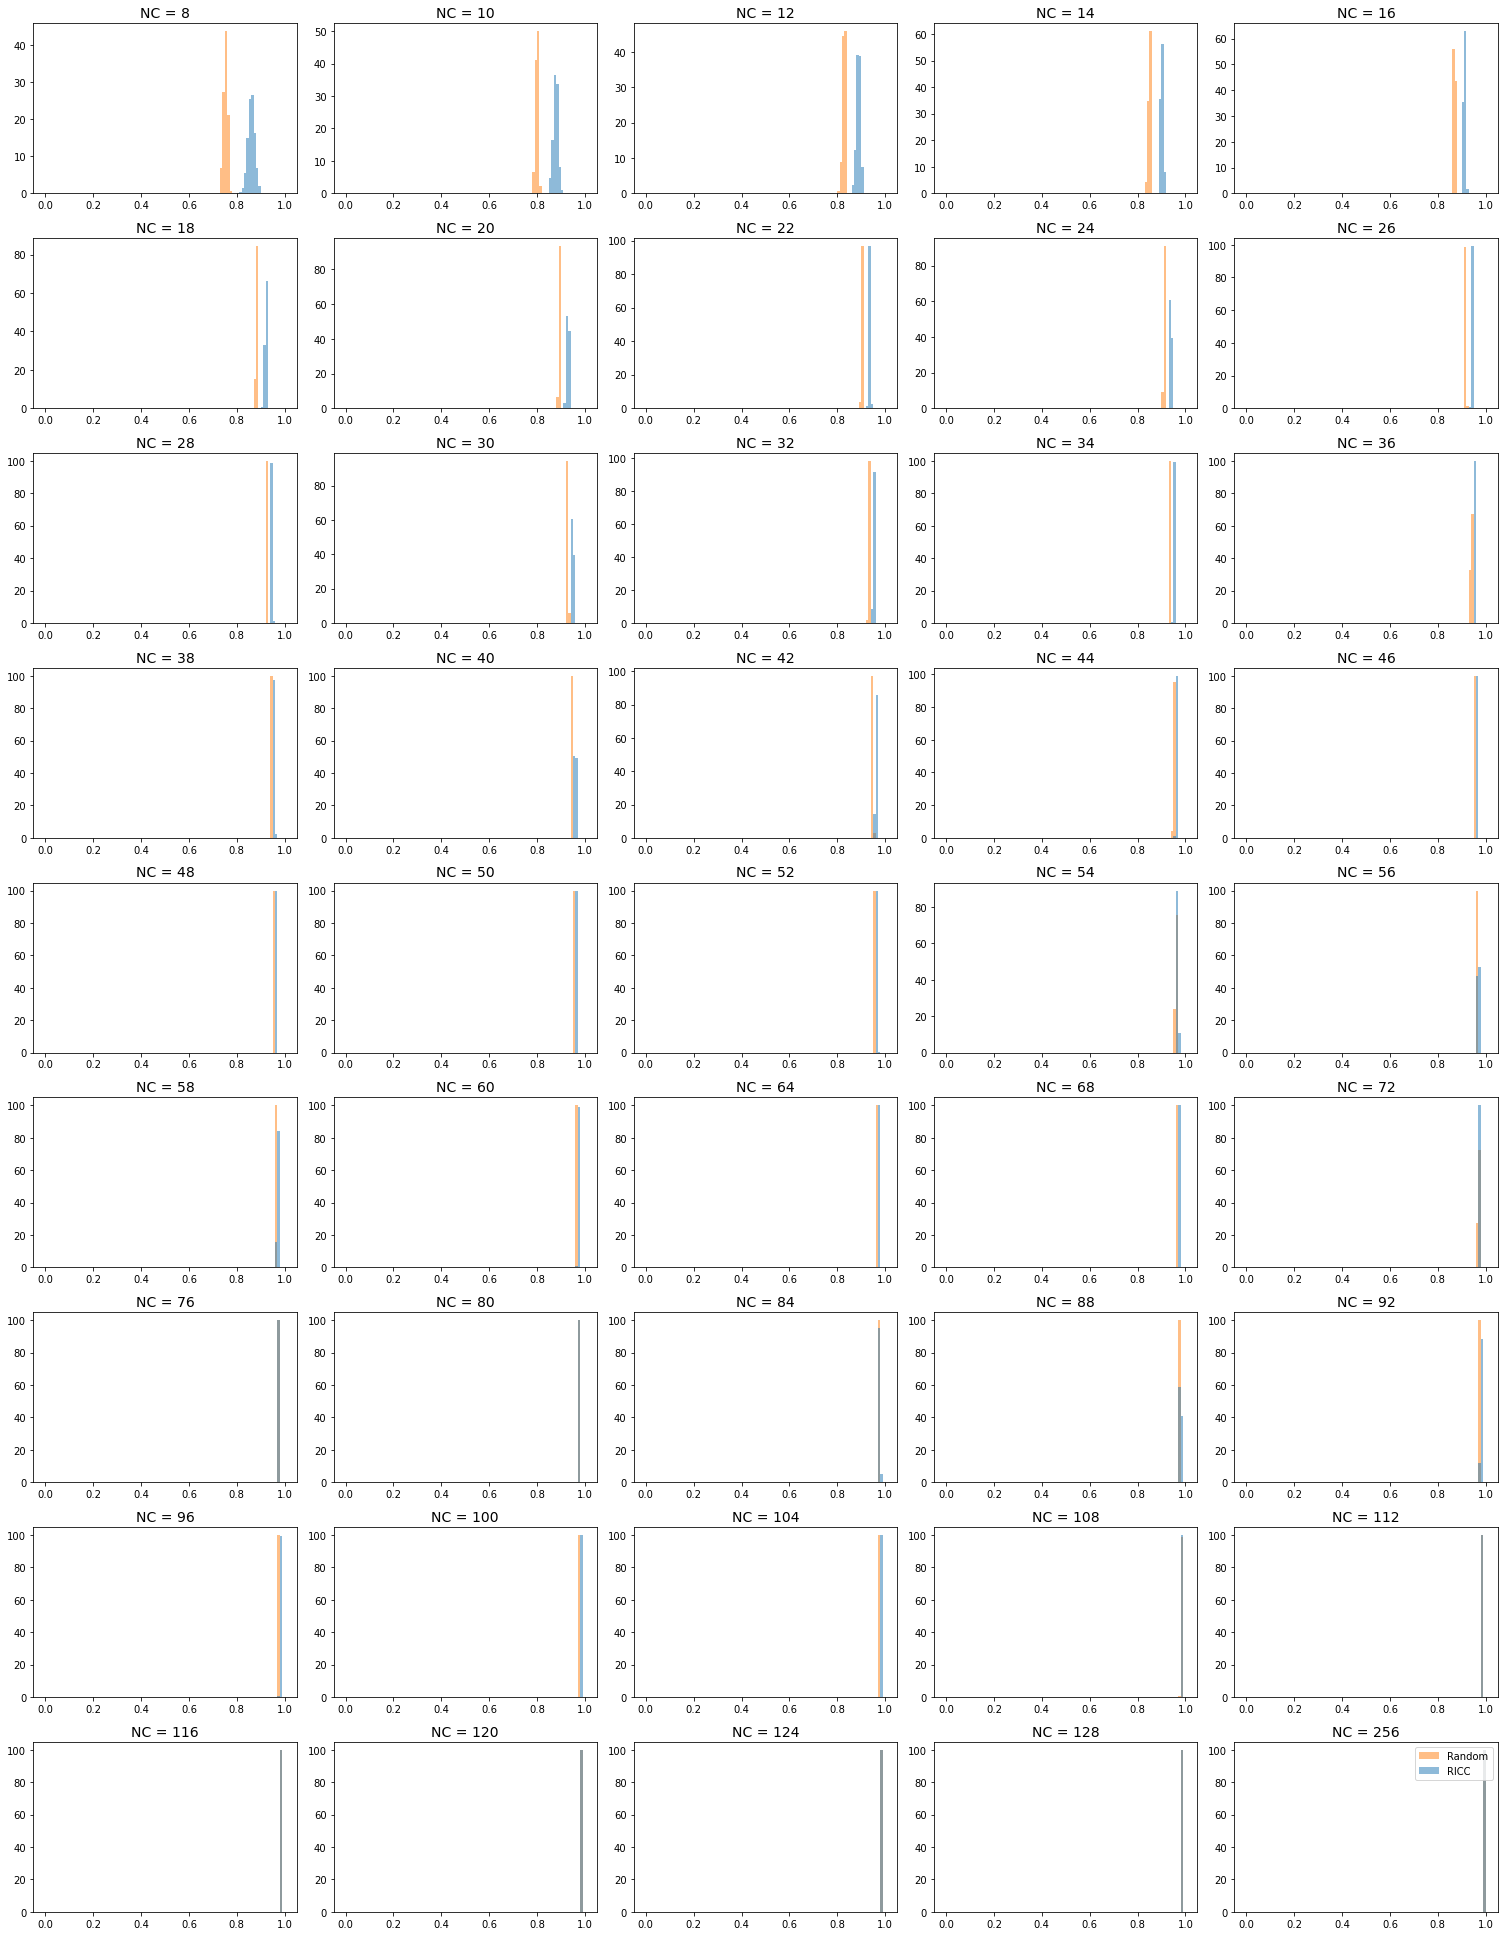

In [158]:
"""
https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.hist.html
"""
# config
nrows=9
ncols=5
fts = 14

# plot
fig = plt.figure(figsize=(ncols*4+1, nrows*3))
bins=np.linspace(0, 1.0, 101)
for idx, nclusters in enumerate(nclusters_list):
    ax = plt.subplot(nrows, ncols, idx+1)
    # Random
    counts, _bins = np.histogram(rscores_pool[nclusters],bins=bins)
    ax.hist(_bins[:-1], bins=_bins, weights=counts, alpha=0.5, density=True, label='Random', color='C1')
    #
    # RICC
    counts, _bins = np.histogram(scores_pool[nclusters],bins=bins)
    ax.hist(_bins[:-1], bins=_bins,  weights=counts, alpha=0.5, density=True, label='RICC', color='C0')
    ax.set_title(f"NC = {nclusters}", fontsize=fts)

plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Ratio of two means  $G/R$

In [20]:
mean_ratios = []
Rs = []
Gs = []
Rstds = []
Gstds = []
eps = 1.0e-6
for idx, nclusters in enumerate(nclusters_list):
    R = np.mean(rscores_pool[nclusters])
    Rstd = np.std(rscores_pool[nclusters])
    G = np.mean(scores_pool[nclusters])
    Gstd = np.std(scores_pool[nclusters])
    Rs.append(R)
    Gs.append(G)
    Rstds.append(Rstd)
    Gstds.append(Gstd)
    mean_ratios.append(G/R)

In [21]:
df = pd.DataFrame(mean_ratios)
df.columns = ['G/R']
df['nclusters'] = nclusters_list

In [22]:
df

,G/R,nclusters
0,1.142769,8
1,1.097300,10
2,1.072944,12
3,1.060638,14
4,1.048897,16
5,1.043851,18
6,1.038836,20
7,1.034846,22
8,1.030344,24
9,1.027877,26


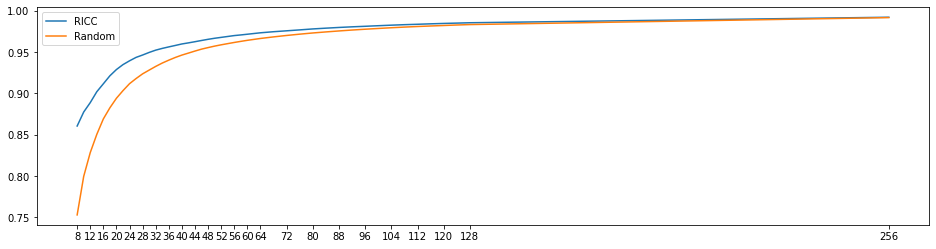

In [160]:
plt.figure(figsize=(16,4))
mytickers = np.arange(8,61,4).tolist()+np.arange(64,129,8).tolist()+[256]
plt.plot(nclusters_list, Gs, label='RICC')
plt.plot(nclusters_list, Rs, label='Random')
plt.legend()
plt.xticks(mytickers)
plt.show()

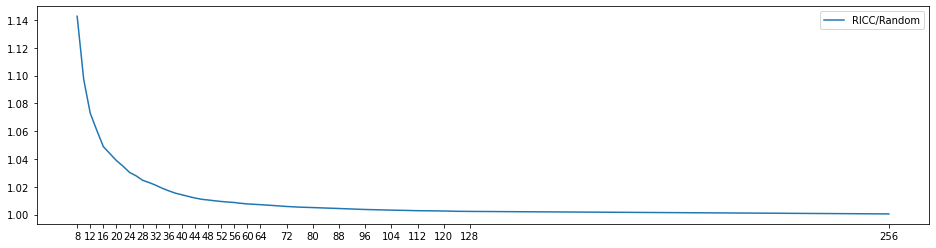

In [161]:
plt.figure(figsize=(16,4))
mytickers = np.arange(8,61,4).tolist()+np.arange(64,129,8).tolist()+[256]
plt.plot(nclusters_list, mean_ratios, label='RICC/Random')
plt.legend()
plt.xticks(mytickers)
plt.show()

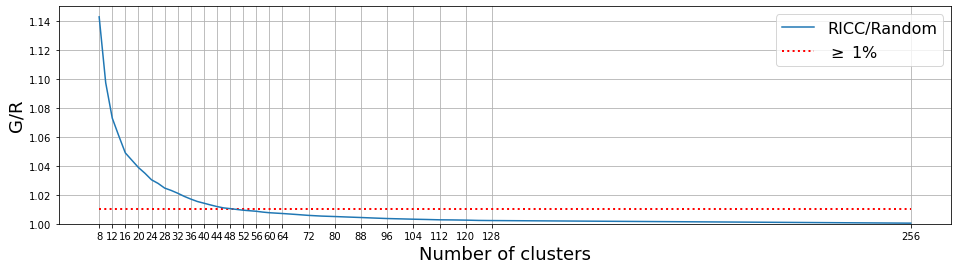

In [48]:
fs=18
fls=16
matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(16,4))
mytickers = np.arange(8,61,4).tolist()+np.arange(64,129,8).tolist()+[256]
#plt.plot(nclusters_list, mean_ratios, label='G/R')
plt.plot(nclusters_list, mean_ratios)

plt.ylim(1.0, 1.15)
plt.xticks(mytickers)
plt.hlines(1.01,8,256, color='red', linewidth=2, linestyle=":" , label='$\geq$ 1%')
plt.grid(True)
#plt.hlines(1.0,8,256, color='black', linewidth=1, linestyle="-" )
#plt.yticks(np.arange(1,1.15,0.01))
plt.ylabel('G/R', fontsize=fs)
plt.xlabel('Number of clusters', fontsize=fs)
plt.legend(fontsize=fls)

## save
pdf = PdfPages(r"significance_stability.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

--------------------
## Similarity of clusterings: Calculate ARI scores

In [36]:
scores_pool = {}
for nclusters, values in labels_pool.items():
    _aris = []
    for (i,j) in itertools.combinations(np.arange(erank),2):
        u = values[i][:npatches]
        v = values[j][:npatches]
        _aris.append(ARI(u , v ) )
    scores_pool[nclusters] = _aris

In [11]:
rscores_pool = {}
for nclusters, values in randoms_pool.items():
    _aris = []
    for (i,j) in itertools.combinations(np.arange(erank),2):
        u = values[i][:npatches]
        v = values[j][:npatches]
        _aris.append(ARI(u , v ) )
    rscores_pool[nclusters] = _aris

### Visualization

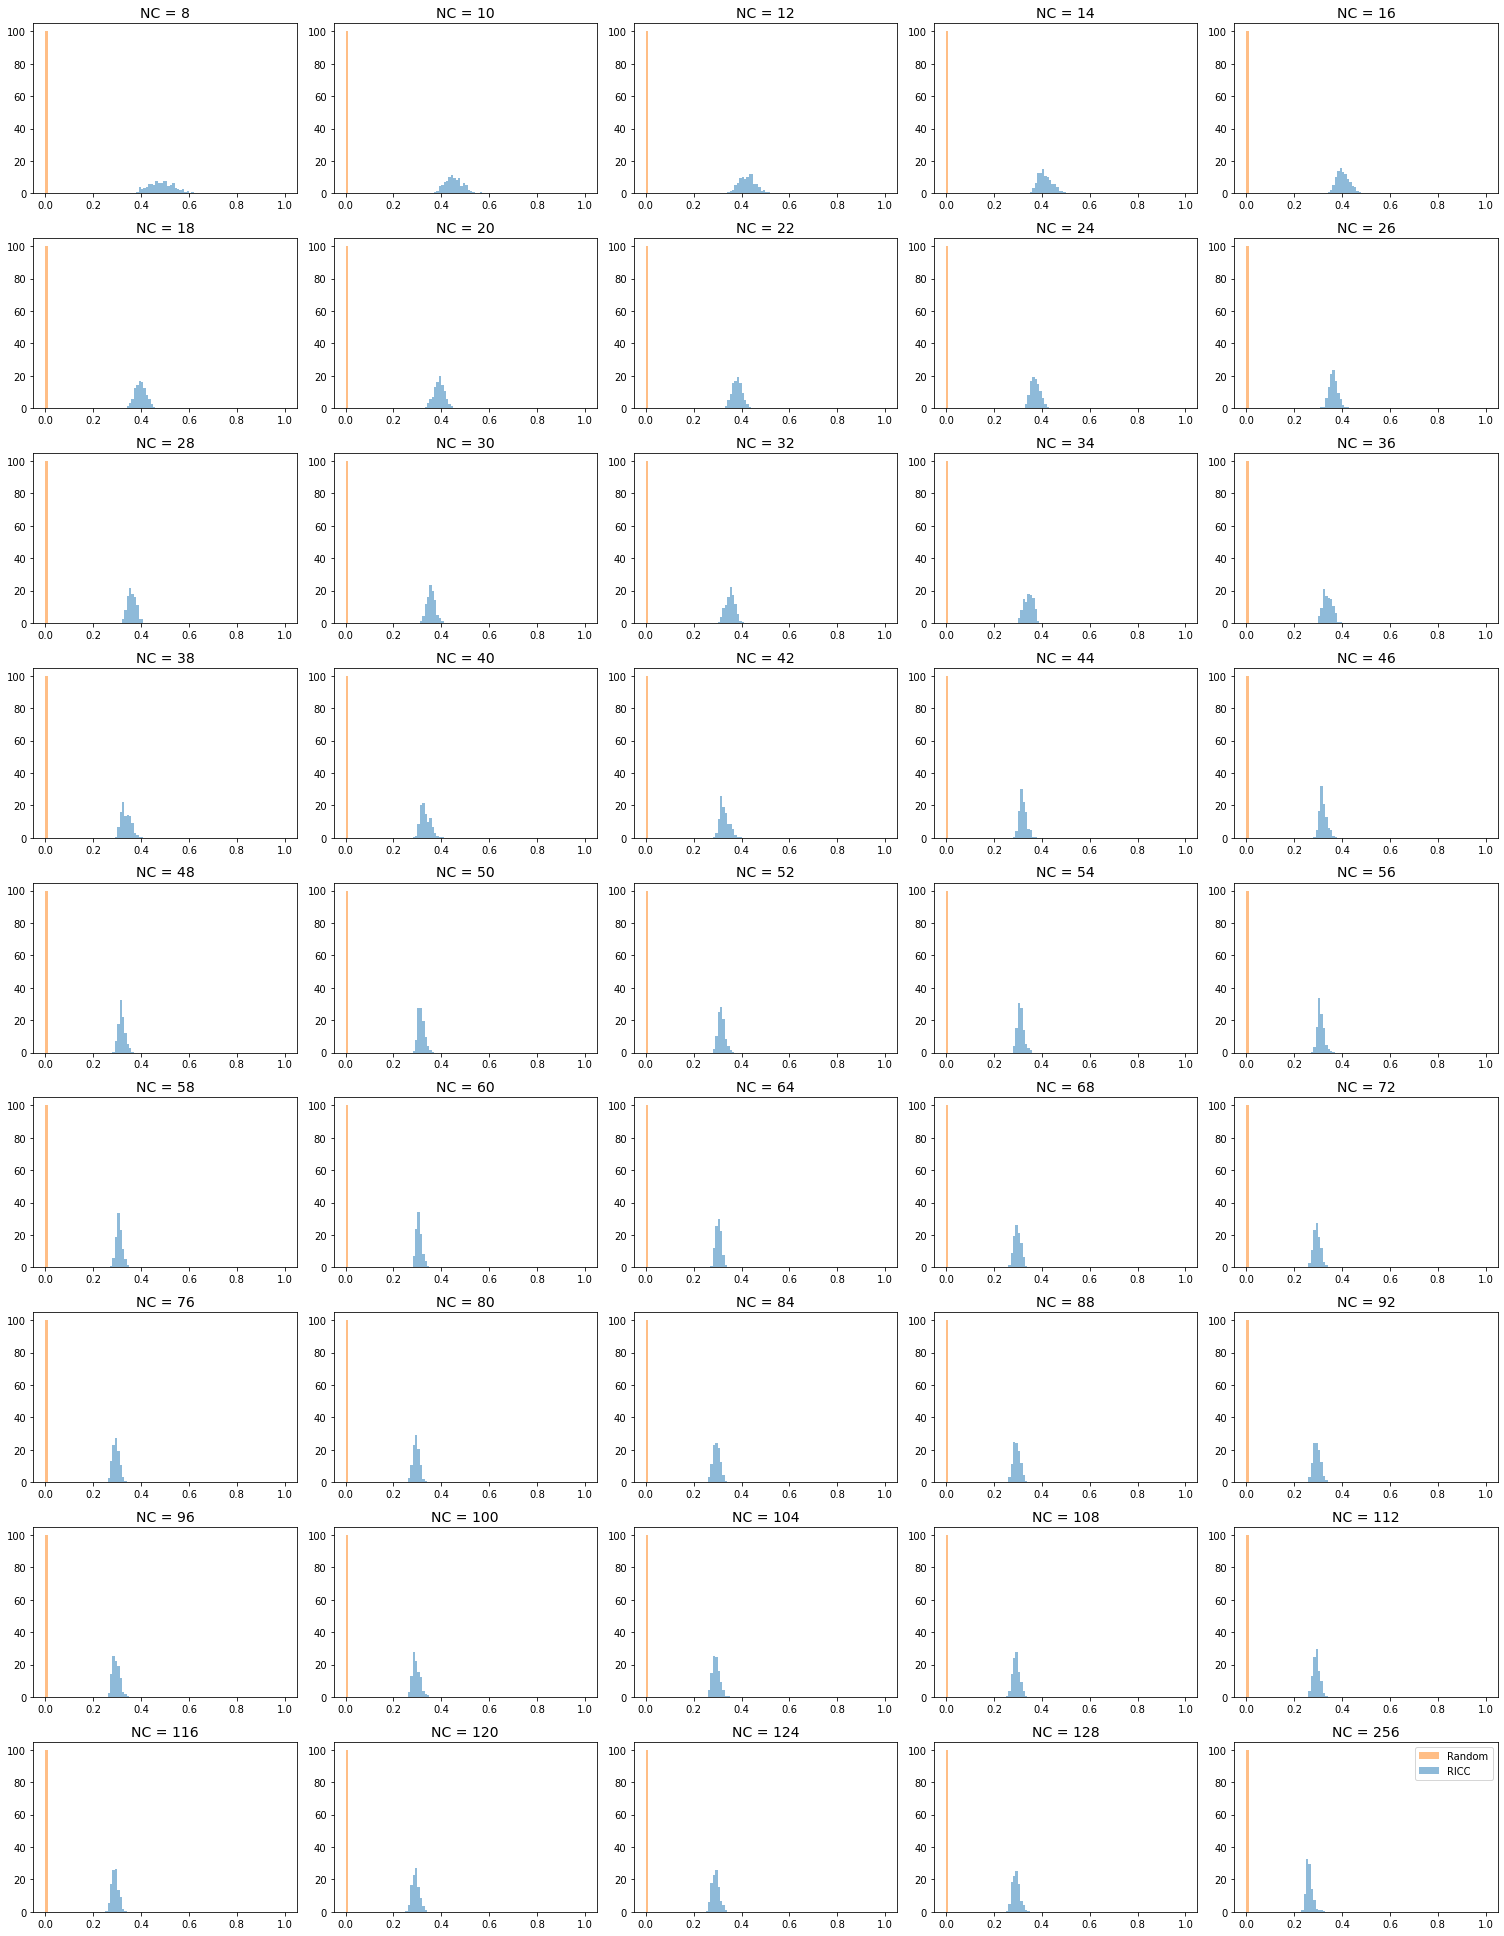

In [13]:
"""
https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.hist.html
"""
# config
nrows=9
ncols=5
fts = 14

# plot
fig = plt.figure(figsize=(ncols*4+1, nrows*3))
bins=np.linspace(0, 1.0, 101)
for idx, nclusters in enumerate(nclusters_list):
    ax = plt.subplot(nrows, ncols, idx+1)
    # Random
    counts, _bins = np.histogram(rscores_pool[nclusters],bins=bins)
    ax.hist(_bins[:-1], bins=_bins, weights=counts, alpha=0.5, density=True, label='Random', color='C1')
    #
    # RICC
    counts, _bins = np.histogram(scores_pool[nclusters],bins=bins)
    ax.hist(_bins[:-1], bins=_bins,  weights=counts, alpha=0.5, density=True, label='RICC', color='C0')
    ax.set_title(f"NC = {nclusters}", fontsize=fts)

plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Ratio of two means  $G/R$

In [12]:
mean_ratios = []
Rs = []
Gs = []
Rstds = []
Gstds = []
eps = 1.0e-6
for idx, nclusters in enumerate(nclusters_list):
    R = np.mean(rscores_pool[nclusters])
    Rstd = np.std(rscores_pool[nclusters])
    G = np.mean(scores_pool[nclusters])
    Gstd = np.std(scores_pool[nclusters])
    Rs.append(R)
    Gs.append(G)
    Rstds.append(Rstd)
    Gstds.append(Gstd)
    mean_ratios.append(G/R)

#### Paper figure 

In [38]:
Gs = []
Gstds = []
for idx, nclusters in enumerate(nclusters_list):
    G = np.mean(scores_pool[nclusters])
    Gs.append(G)

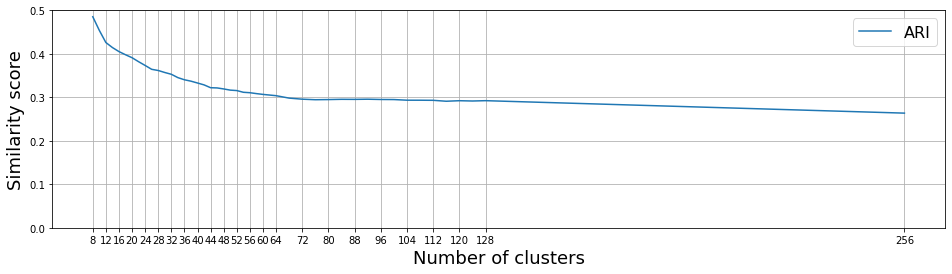

In [42]:
fs=18
fls=16
plt.figure(figsize=(16,4))
mytickers = np.arange(8,61,4).tolist()+np.arange(64,129,8).tolist()+[256]
plt.plot(nclusters_list, Gs, label='ARI')

plt.ylim(0.0, 0.50)
plt.xticks(mytickers)
plt.grid(True)
plt.ylabel('Similarity score', fontsize=fs)
plt.xlabel('Number of clusters', fontsize=fs)
plt.legend(fontsize=fls)

## save
pdf = PdfPages(r"similarity_ari.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

-----------------------
## Paper quality figures

#### RI ratio

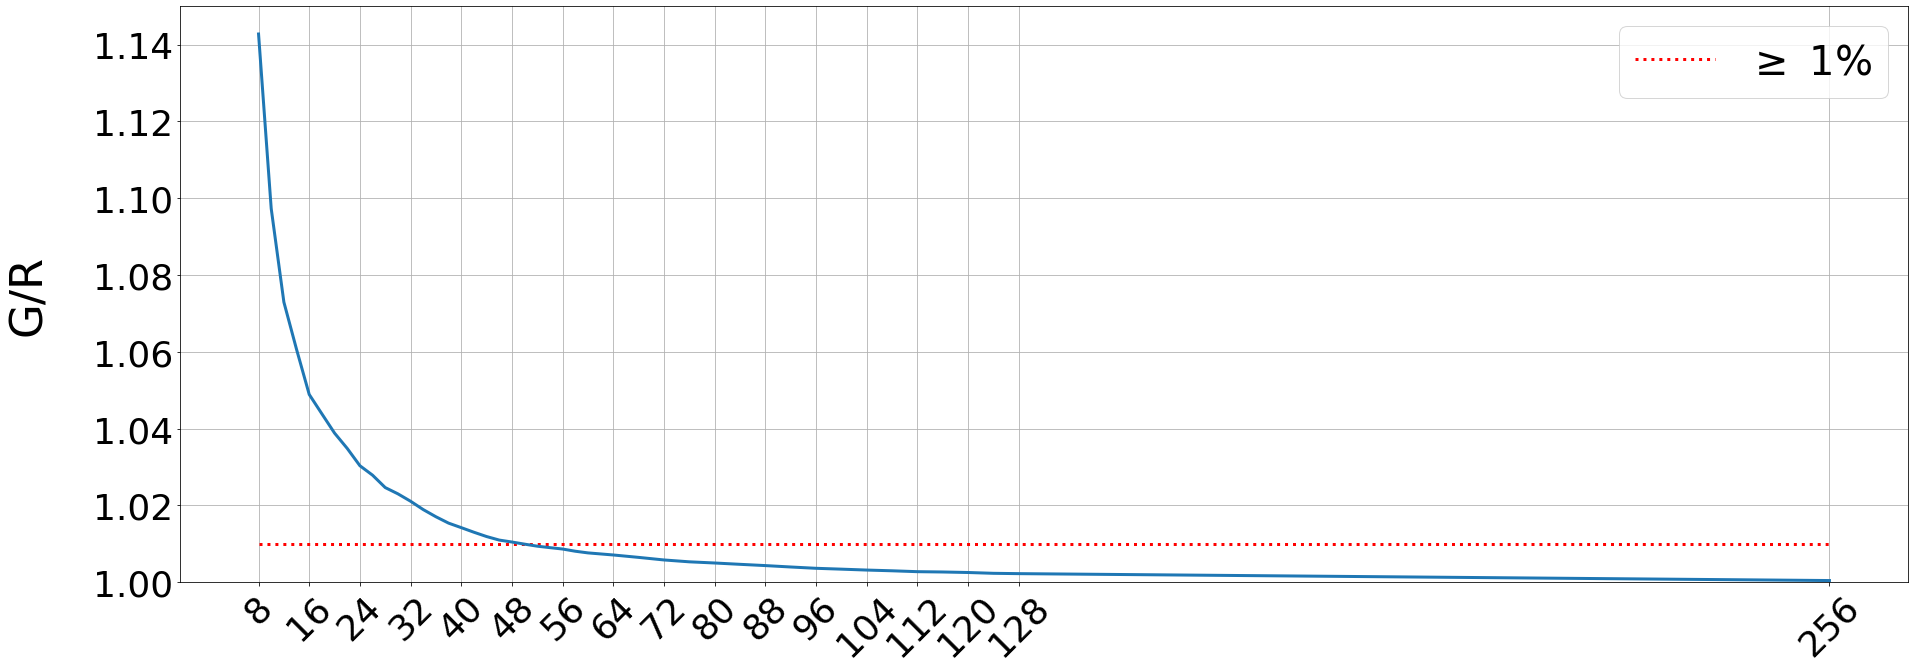

In [24]:
# first version: too small
#fs=18
#fls=16
# matplotlib.rcParams.update({'font.size': 10})

# second
#fs=35
fs=45 #35
fls=40 #30
lw=3 #linewidth
matplotlib.rcParams.update({'font.size': 36})

#plt.figure(figsize=(16,4))
#plt.figure(figsize=(24,6))
fig = plt.figure(figsize=(24,8))
mytickers = np.arange(8,61,8).tolist()+np.arange(64,129,8).tolist()+[256]
#plt.plot(nclusters_list, mean_ratios, label='G/R', linewidth=lw)
plt.plot(nclusters_list, mean_ratios,  linewidth=lw)

plt.ylim(1.0, 1.15)
plt.xticks(mytickers,rotation = 45)
plt.hlines(1.01,8,256, color='red', linewidth=lw, 
           linestyle=":" , label='$\geq$ 1%')
plt.grid(True)
#plt.hlines(1.0,8,256, color='black', linewidth=1, linestyle="-" )
plt.yticks(np.arange(1,1.15,0.02))
plt.legend(fontsize=fls)

#fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#fig.text(-0.1, 0.5, r'${Stab}_{RICC} / {Stab}_{null}$', 
#         fontsize=fs, va='center', rotation='vertical')
fig.text(-0.1, 0.5, 'G/R', 
         fontsize=fs, va='center', rotation='vertical')
#plt.ylabel(r'${Stab}_{RICC}/{Stab}_{null}$', fontsize=fs)
#plt.xlabel('Number of clusters', fontsize=fs)

## save
#plt.show()
pdf = PdfPages(r"significance_stability_gr.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

#### ARI score

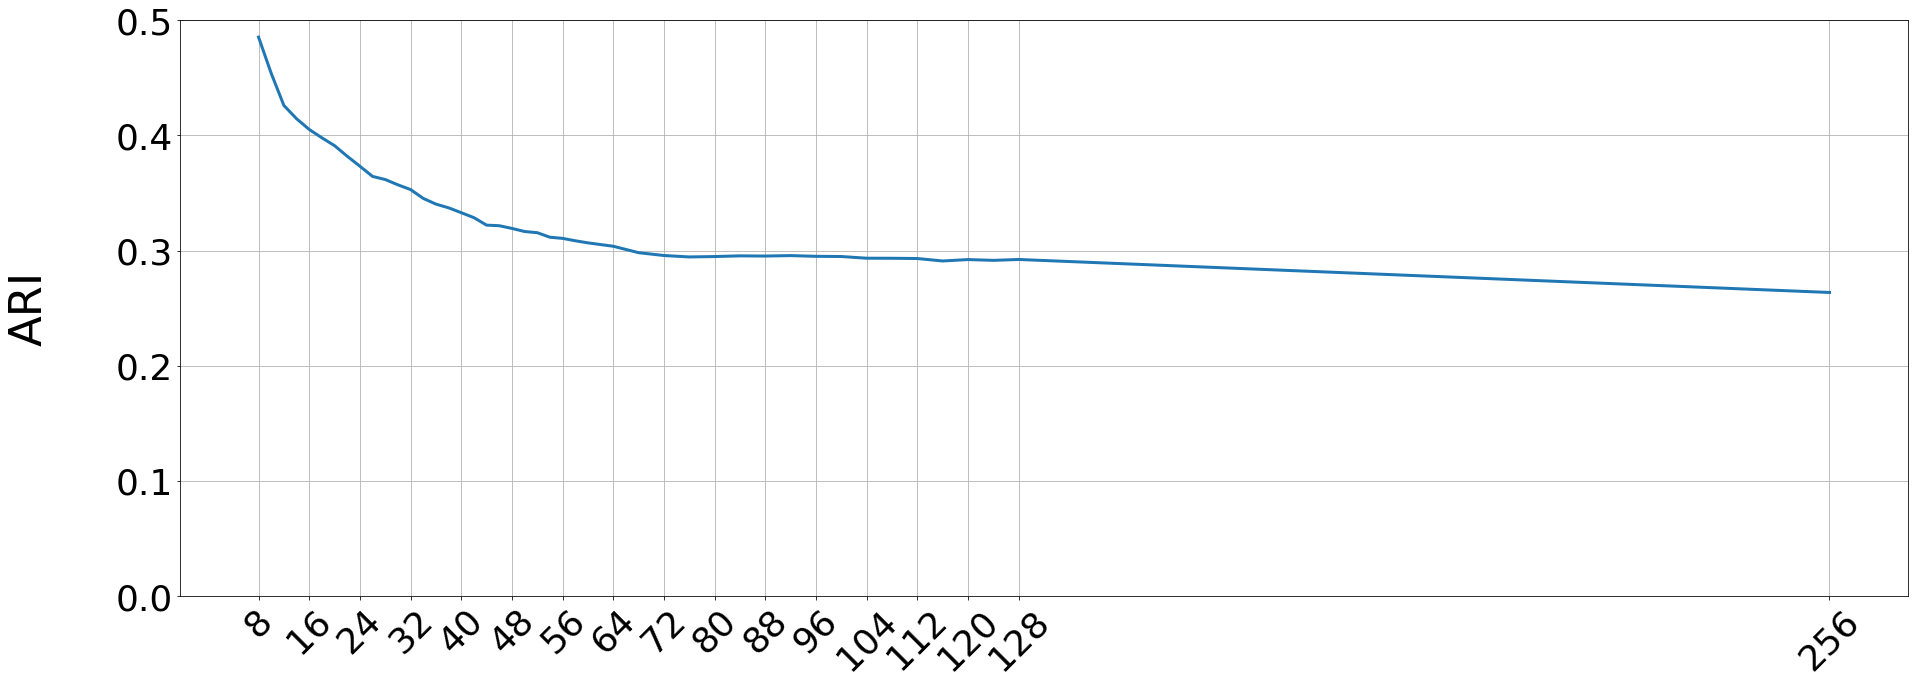

In [76]:
# second
#fyl=35 #  16
#fts=45 #16
fs=45 #35
fls=30
lw=3 #linewidth
matplotlib.rcParams.update({'font.size': 36})
mytickers = np.arange(8,61,8).tolist()+np.arange(64,129,8).tolist()+[256]

fig = plt.figure(figsize=(24,8))
#plt.figure(figsize=(24,6))
plt.plot(nclusters_list, Gs, label='ARI', linewidth=lw)

plt.ylim(0.0, 0.50)
plt.xticks(mytickers,rotation = 45)
plt.grid(True)

#plt.ylabel('ARI', fontsize=fs)
#plt.xlabel('Number of clusters', fontsize=fs)
#plt.legend(fontsize=fls)
#fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#fig.text(0.5, -0.04, 'Number of clusters', fontsize=fs, ha='center')
fig.text(-0.1, 0.5, 'ARI', fontsize=fs, va='center', rotation='vertical')


## save
pdf = PdfPages(r"similarity_ari.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None